In [ ]:
from pixell import utils, enmap, bunch, reproject, colors, coordinates

import numpy as np

import matplotlib.pyplot as plt

import map_utils as utils
from optical_loading import pwv_interp, bandpass_interp
from abscal import T_b

import dill as pk

from sotodlib import core

from glob import glob

from astropy.modeling import models
from astropy import units as u
from astropy.convolution import convolve, Gaussian2DKernel

from scipy.integrate import quad
from scipy.interpolate import interp1d

# Display inline plots
%matplotlib inline

%load_ext autoreload
%autoreload 2

/so/home/jorlo/venvs/sotodlib/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:

    
with open("beams.pk", "rb") as f:
    beam_dict = pk.load(f)

In [6]:
obs_id = "1745105172"
path = "/so/home/saianeesh/data/beams/lat/source_maps/mars/{}/".format(obs_id[:5])
#path = "/so/home/saianeesh/data/first_light_unfocused/source_maps/mars/"

ot = "i1"
obs = f"obs_{obs_id}_lat{ot}_111/"

glob(path+obs+"*_solved.fits")

['/so/home/saianeesh/data/beams/lat/source_maps/mars/17451/obs_1745105172_lati1_111/obs_1745105172_lati1_111_ufm_mv21_f150_solved.fits',
 '/so/home/saianeesh/data/beams/lat/source_maps/mars/17451/obs_1745105172_lati1_111/obs_1745105172_lati1_111_ufm_mv24_f150_solved.fits',
 '/so/home/saianeesh/data/beams/lat/source_maps/mars/17451/obs_1745105172_lati1_111/obs_1745105172_lati1_111_ufm_mv21_f090_solved.fits',
 '/so/home/saianeesh/data/beams/lat/source_maps/mars/17451/obs_1745105172_lati1_111/obs_1745105172_lati1_111_ufm_mv24_f090_solved.fits']

In [7]:

wafer = "mv24"
band = "150"
map_file = f"obs_{obs_id}_lat{ot}_111_ufm_{wafer}_f{band}"
solved = enmap.read_map(path+obs+map_file+"_solved.fits")[0]
weights = enmap.read_map(path+obs+map_file+"_weights.fits")[0][0]
binned = enmap.read_map(path+obs+map_file+"_binned.fits")[0]


In [8]:
if "mv" in wafer:
    ufm_type = "MF"
    if band == "090":
        ufm_band = "MF_1"
    elif band == "150":
        ufm_band = "MF_2"
elif "uv" in wafer:
    ufm_type = "UHF"
    if band == "220":
        ufm_band = "UHF_1"
    elif band == "280":
        ufm_band = "UHF_2"
else:
    ufm_type = "LF"
    if band == "030":
        ufm_band = "LF_1"
    elif band == "040":
        ufm_band = "LF_2"


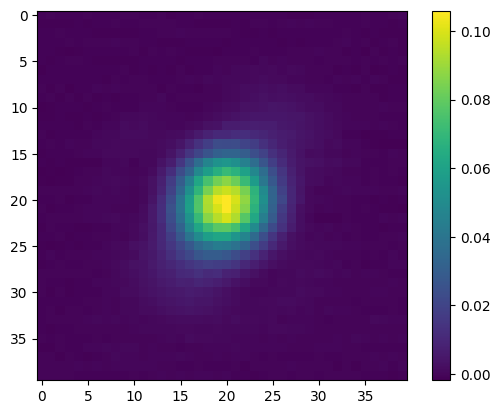

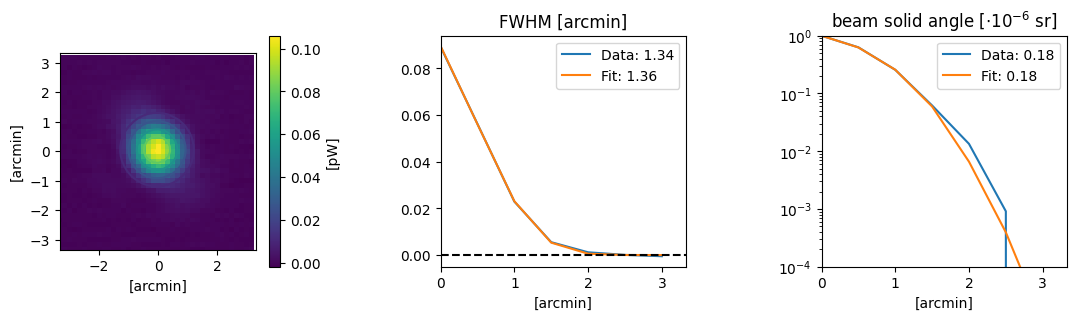

In [9]:


kernel = Gaussian2DKernel(5)
smoothed = convolve(solved, kernel)
cent = np.argmax(smoothed)
cent = np.unravel_index(cent, solved.shape)
pixsize = np.abs(solved.wcs.wcs.cdelt[0]*60)

r = 20
solved = solved[cent[0]-r:cent[0]+r,cent[1]-r:cent[1]+r]
weights = weights[cent[0]-r:cent[0]+r,cent[1]-r:cent[1]+r]
binned = binned[cent[0]-r:cent[0]+r,cent[1]-r:cent[1]+r]
plt.imshow(solved)
plt.colorbar()
pixmap = enmap.pixmap(solved.shape, solved.wcs)
fitted_amp, shift_x, shift_y, fitted_fwhm, data_solid_angle, chisred, popt, pcov = utils.fit_gauss_pointing(solved, weights, pixmap, make_plots=True)


In [10]:
fitted_amp = beam_dict[map_file[4:]]["amp"]
data_solid_angle = beam_dict[map_file[4:]]["omega"]
chisred = beam_dict[map_file[4:]]["chisred"]

In [11]:
if chisred >= 100:
    print("WARNING: HIGH CHISQ RED")

# Scale Observed Amp to 1mm PWV, el = 50 deg

In [12]:
import datetime as dt

from so3g.hk import load_range
import requests
from io import StringIO

with open("atmosphere_eff.pk", "rb") as f:
    atmosphere_eff = pk.load(f)
# If you have more than one observation, you can load PWV between the start and end timestamps
# otherwise set the start and end to the same obs

start_timestamp = int(obs_id)
end_timestamp = int(obs_id)

start_date = dt.datetime.utcfromtimestamp(start_timestamp) - dt.timedelta(days=1)
end_date = dt.datetime.utcfromtimestamp(end_timestamp) + dt.timedelta(days=1)

fiducial_elevation = 50
fiducial_pwv = 1 # mm

el_key = "50" #hardcoded :(
pwv_idx = np.where(np.array([np.abs(pwv - fiducial_pwv) < 0.1 for pwv in atmosphere_eff['pwv']]))[0]


In [13]:
pwv = pwv_interp()

In [14]:
pwv_obs = pwv(obs_id)

ctx = core.Context('/so/metadata/lat/contexts/smurf_detsets.yaml')
meta = ctx.get_meta(obs.strip("/"))

el_obs = meta.obs_info.el_center

In [15]:
obs_idx_pwv = np.where(np.isclose(np.abs(atmosphere_eff['pwv'] - pwv_obs), np.min(np.abs(atmosphere_eff['pwv'] - pwv_obs))))[0][0]
obs_key_el = [el for el in atmosphere_eff['LF']["LF_1"].keys() if np.abs(int(el) - el_obs) < 2.5][0]

In [16]:
t_atm_obs = atmosphere_eff[ufm_type][ufm_band][obs_key_el][obs_idx_pwv]
t_atm_fiducial = atmosphere_eff[ufm_type][ufm_band][el_key][pwv_idx]

In [17]:
pwv_adjust = t_atm_fiducial / t_atm_obs

## Scale to fiducial size

In [222]:

mars_diameter = utils.get_planet_diameter(int(obs_id), "Mars") # arcsec, we are using exact temperatures


## Calculate abs cal

In [19]:
def data_to_cal_factor(p_meas, beam_solid_angle, band, wafer, mars_diameter, obs_id):
    fiducial_solid_angle = utils.angular_diameter_to_solid_angle(mars_diameter)

    timestamp = str(obs_id)
    planet_temp = T_b[timestamp]
    
    fill_factor = (fiducial_solid_angle / (beam_solid_angle * 1e-6))
    t_eff_planet = planet_temp[band] *fill_factor
    cal_factor = t_eff_planet / p_meas # K -> pW
    
    bandpass = bandpass_interp(band, wafer)
    bb = models.BlackBody(temperature=T_b[str(obs_id)][band]*u.K)


    xspace = np.linspace(10, 220, 1000)*u.GHz 
    yspace = bb(xspace) * bandpass(xspace.value)
    out = np.trapezoid(yspace, xspace)

    opt_eff = ((fitted_amp)/(out.to(u.pW/u.sr/u.cm**2) * fill_factor * (float(band) * u.GHz).to(u.cm, equivalencies=u.spectral())**2)).value 
    
    return cal_factor, opt_eff

adjusted_amplitude = fitted_amp * pwv_adjust[0]

cal_factor, opt_eff = data_to_cal_factor(adjusted_amplitude, data_solid_angle, band, wafer, mars_diameter, obs_id)
raw_factor, _ = data_to_cal_factor(fitted_amp, data_solid_angle, band, wafer, mars_diameter, obs_id)

print(f"Measured calibration factor = {cal_factor:.2f} K -> pW (RJ Units)")
print(f"Measured optical efficiency = {opt_eff:.3f}")
#print(f"Efficiency from inst model = {efficiency * 100:.2f} %")

with open("abscals.pk", "rb") as f:
    abscal_dict = pk.load(f)
    
abscal_dict[map_file] = cal_factor

with open("abscals.pk", "wb") as f:
    pk.dump(abscal_dict, f)

Measured calibration factor = 8.85 K -> pW (RJ Units)
Measured optical efficiency = 0.125


In [20]:
opt_eff * data_solid_angle *1e-6 / utils.angular_diameter_to_solid_angle(fitted_fwhm*60)

np.float64(0.18052724700922765)

In [21]:
utils.angular_diameter_to_solid_angle(mars_diameter)/(data_solid_angle*1e-6)

np.float64(0.005268633533139799)

In [22]:
fitted_fwhm

np.float64(1.3570274495276096)

In [23]:
with open("r3v8_sim.pk", "rb") as f:
    sim = pk.load(f)

for flavor in ['MF', 'UHF']:
    for kind in ['baseline', 'goal']:
        print(flavor, kind)
        for ch in sim[flavor][kind].keys():
            print("\t", ch, f"eta={sim[flavor][kind][ch]['det_eff']}  ", 'K_RJ / pW', 1.0/(1e12*sim[flavor][kind][ch]['dpdt_rj']) )

MF baseline
	 MF_1 eta=0.974   K_RJ / pW 18.871016107107586
	 MF_2 eta=0.57   K_RJ / pW 9.911860127294345
MF goal
	 MF_1 eta=1.08   K_RJ / pW 14.38473230901672
	 MF_2 eta=0.669   K_RJ / pW 7.624657050421212
UHF baseline
	 UHF_1 eta=0.581   K_RJ / pW 5.317190203726212
	 UHF_2 eta=0.636   K_RJ / pW 4.72122772765332
UHF goal
	 UHF_1 eta=0.74   K_RJ / pW 3.283290861516907
	 UHF_2 eta=0.718   K_RJ / pW 3.5883133394803957


## Get a nearby CMB Scan

In [24]:
ctx = core.Context('./smurf_det_preproc.yaml')

start_date = dt.datetime.utcfromtimestamp(start_timestamp) - dt.timedelta(days=1)
end_date = dt.datetime.utcfromtimestamp(end_timestamp) + dt.timedelta(days=1)

obs_list = ctx.obsdb.query(
    f"{end_date.timestamp()} > timestamp and timestamp > {start_date.timestamp()} and type=='obs' and subtype=='cmb'"
)

In [25]:
timestamps = np.zeros(len(obs_list))
for i, cur_obs in enumerate(obs_list):
    if wafer in cur_obs["stream_ids_list"]:
        timestamps[i] = cur_obs["timestamp"]

flag = np.where((np.abs(timestamps-int(obs_id))==np.amin(np.abs(timestamps-int(obs_id)))))[0][0]

meta = ctx.get_meta(obs_list[flag]["obs_id"])
wafer_flag = np.array([wafer in ufm for ufm in meta.det_info.stream_id])

bp = (meta.det_cal.bg % 4) // 2 
    
if int(ufm_band[-1]) == 1:
    net_flag = wafer_flag * (bp==0)
elif int(ufm_band[-1]) == 2:
    net_flag = wafer_flag * (bp==1)

In [27]:
meta.preprocess.psd

AxisManager(freqs[nusamps], Pxx[dets,nusamps], valid[dets,samps], dets:LabelAxis(5152), samps:OffsetAxis(119005), nusamps:OffsetAxis(2049))

(5, 50)

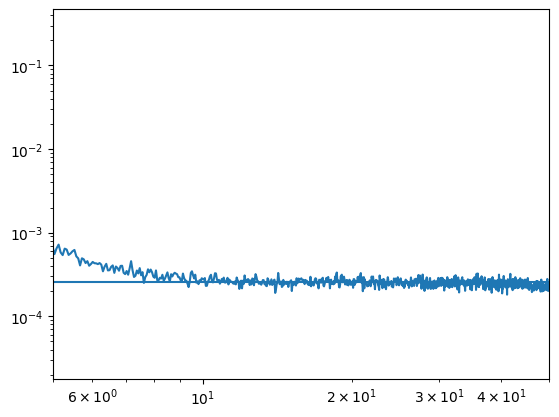

In [44]:
plt.plot(meta.preprocess.psd.freqs, np.sqrt(meta.preprocess.psd.Pxx[5148]))
plt.xscale("log")
plt.yscale("log")
plt.hlines(meta.preprocess.noise.white_noise[5148], 5, 50)
plt.xlim(5, 50)

np.float32(0.00026046453)

In [176]:
print("Num good dets: ", len(np.where((meta.preprocess.noise.white_noise[net_flag] != 0))[0]))

Num good dets:  697


In [177]:
net_mes = 1/np.sqrt(2) * meta.preprocess.noise.white_noise[net_flag] * raw_factor 

In [178]:
test = []
for net in net_mes:
    if net*1e6 >= 125:
        test.append(net)
test = np.array(test)


(np.nansum((test*1e6)**(-2)))**(-1/2) * 1.08 / np.sqrt(12)

np.float64(19.885941830560217)

(array([21.,  0.,  0.,  1.,  0.,  3.,  9., 34., 90.]),
 array([ 0.        ,  4.44444444,  8.88888889, 13.33333333, 17.77777778,
        22.22222222, 26.66666667, 31.11111111, 35.55555556, 40.        ]),
 <BarContainer object of 9 artists>)

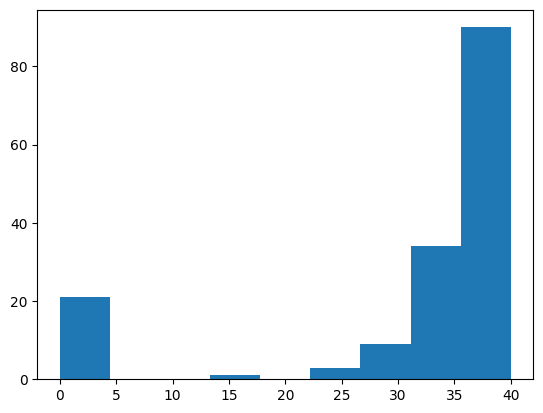

In [179]:
plt.hist(meta.preprocess.noise.white_noise[net_flag] * meta.det_cal.phase_to_pW[net_flag] * 1e6, bins=np.linspace(0,40,10))

(array([  0.,   0.,   0.,   1.,   0.,   1.,  39., 249.,  98.]),
 array([  0.        ,  55.55555556, 111.11111111, 166.66666667,
        222.22222222, 277.77777778, 333.33333333, 388.88888889,
        444.44444444, 500.        ]),
 <BarContainer object of 9 artists>)

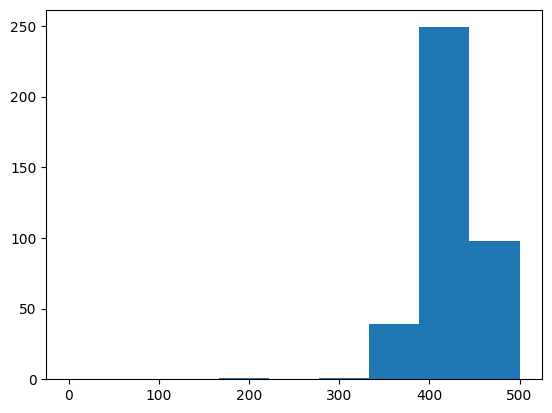

In [120]:
plt.hist(test * 1e6, bins = np.linspace(0, 5e2, 10))

(array([349.,   8.,   1.,   1.,   0.,   1.,  39., 249.,  98.]),
 array([  0.        ,  55.55555556, 111.11111111, 166.66666667,
        222.22222222, 277.77777778, 333.33333333, 388.88888889,
        444.44444444, 500.        ]),
 <BarContainer object of 9 artists>)

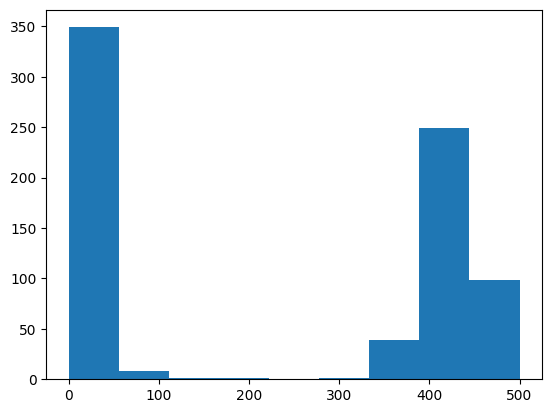

In [121]:
plt.hist(net_mes * 1e6, bins = np.linspace(0, 5e2, 10))

In [122]:
try:
    with open("nets.pk", "rb") as f:
        net_dict = pk.load(f)
except FileNotFoundError:
    net_dict = {}
    
net_dict[map_file] = {}
net_dict[map_file]["nets"] = net_mes
net_dict[map_file]["pwv"] = pwv_obs
net_dict[map_file]["el"] = el_obs

with open("nets.pk", "wb") as f:
    pk.dump(net_dict, f)

In [123]:
flags = [phase for i, phase in enumerate(meta.det_cal.phase_to_pW[net_flag]) if 50 < net_mes[i]*1e6 < 125]

In [124]:
np.mean(flags)

np.float64(0.12424993287333273)

In [125]:
np.nanmean(meta.det_cal.phase_to_pW[net_flag])

np.float64(0.15345243457100607)

(array([3., 1., 0., 0., 0., 0., 0., 1., 2., 2.]),
 array([0.07771006, 0.08649846, 0.09528687, 0.10407527, 0.11286367,
        0.12165208, 0.13044048, 0.13922888, 0.14801729, 0.15680569,
        0.1655941 ]),
 <BarContainer object of 10 artists>)

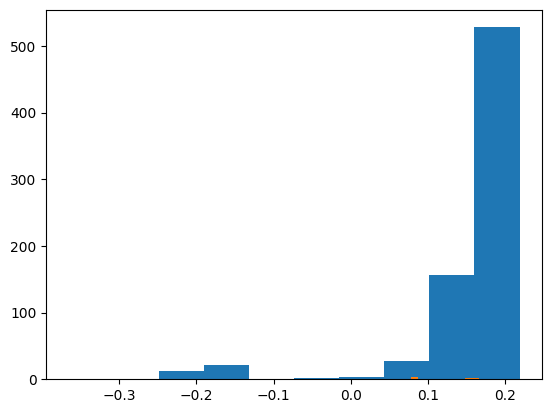

In [126]:
plt.hist(meta.det_cal.phase_to_pW[net_flag])
plt.hist(flags)


In [127]:
net_dict.keys()

dict_keys(['obs_1745105172_latc1_111_ufm_uv39_f220'])

(array([4.573e+03, 2.180e+02, 2.800e+01, 1.000e+01, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00]),
 array([0.        , 0.00090027, 0.00180055, 0.00270082, 0.00360109,
        0.00450137, 0.00540164, 0.00630191, 0.00720218, 0.00810246,
        0.00900273]),
 <BarContainer object of 10 artists>)

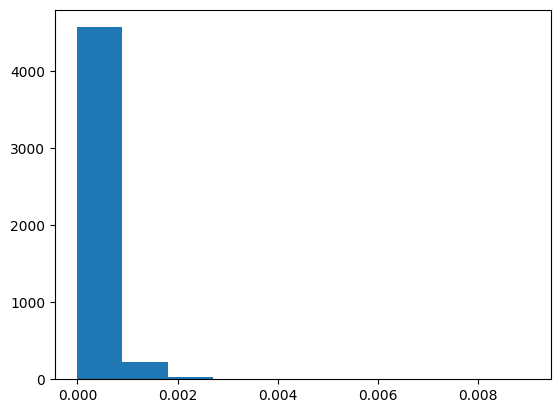

In [128]:
plt.hist(meta.preprocess.noise.white_noise)

In [129]:
len([noise for noise in meta.preprocess.noise.white_noise if noise == 0.])

1975

# Results

In [9]:
with open("results_05012025.pk", "rb") as f:
    result_dict = pk.load(f)
    
with open("r3v8_sim.pk", "rb") as f:
    sim = pk.load(f)
    
import seaborn as sns
import pandas as pd

In [10]:
labels = []
cals = []
chis = []
obs = []

freqs = ["090", "150", "220", "280"]
ufms = sorted(result_dict.keys())

for freq in freqs: #This is slighly inefficient but the ezest way to sort by freq then ufm
    for ufm in ufms:
        for key in result_dict.keys():
            if ufm not in key:
                continue
            for sub_key in result_dict[key].keys():
                if freq not in sub_key:
                    continue
                cur_chis = np.array(result_dict[key][sub_key]["chi"])
                flags = np.where((25<= cur_chis) & (cur_chis<=1000))[0]
                cur_cals = np.array(result_dict[key][sub_key]["cal"])[flags]
                cur_chis = cur_chis[flags]
                cur_obs = np.array(result_dict[key][sub_key]["obs"])[flags]

                label = str(freq)+"_"+str(ufm)
                for j in range(len(cur_cals)):
                    cals.append(cur_cals[j])
                    chis.append(cur_chis[j])
                    labels.append(label)
                    obs.append(cur_obs[j])


"""
for key in enumerate(result_dict.keys()):
    for sub_key in result_dict[key].keys():
        cur_chis = np.array(result_dict[key][sub_key]["chi"])
        flags = np.where((25<= cur_chis) & (cur_chis<=1000))[0]
        cur_cals = np.array(result_dict[key][sub_key]["cal"])[flags]
        cur_chis = cur_chis[flags]
        cur_obs = np.array(result_dict[key][sub_key]["obs"])[flags]
        
        label = str(key)+"_"+str(sub_key)
        for j in range(len(cur_cals)):
            cals.append(cur_cals[j])
            chis.append(cur_chis[j])
            labels.append(label)
            obs.append(cur_obs[j])
"""
labels = np.array(labels)
cals = np.array(cals)
chis = np.array(chis)
obs = np.array(obs)

df = pd.DataFrame({'labels': labels, 'cals': cals, 'chis': chis, 'obs': obs})
    

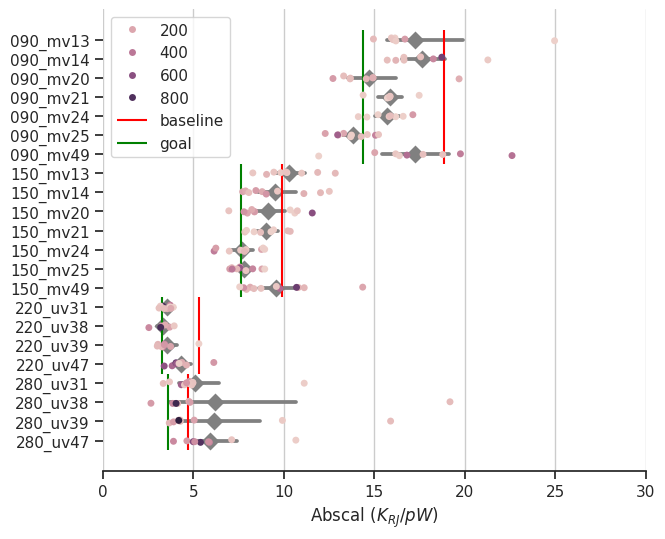

In [12]:
sns.set_theme(style="ticks")

# Initialize the figure with a logarithmic x axis
f, ax = plt.subplots(figsize=(7, 6))
#ax.set_xscale("log")

# Load the example planets dataset
#planets = sns.load_dataset("planets")

# Plot the orbital period with horizontal boxes
#sns.boxplot(
#    planets, x="distance", y="method", hue="method",
#    whis=[0, 100], width=.6, palette="vlag"
#)

# Add in points to show each observation
sns.stripplot(df, x="cals", y="labels", hue="chis")

sns.pointplot(data=df, x="cals", y="labels", linestyle="none", marker="D", color="0.5")

ymax, ymin = ax.get_ylim()
plt.vlines(1.0/(1e12*(sim["MF"]["baseline"]["MF_1"]["dpdt_rj"])), ymin = ymin, ymax = 6.5, label="baseline", color="red")
plt.vlines(1.0/(1e12*(sim["MF"]["goal"]["MF_1"]["dpdt_rj"])), ymin = ymin, ymax = 6.5, label="goal", color="green")

plt.vlines(1.0/(1e12*(sim["MF"]["baseline"]["MF_2"]["dpdt_rj"])), ymin = 6.5, ymax = 13.5, label=None, color="red")
plt.vlines(1.0/(1e12*(sim["MF"]["goal"]["MF_2"]["dpdt_rj"])), ymin = 6.5, ymax = 13.5, label=None, color="green")

plt.vlines(1.0/(1e12*(sim["UHF"]["baseline"]["UHF_1"]["dpdt_rj"])), ymin = 13.5, ymax = 17.5, label=None, color="red")
plt.vlines(1.0/(1e12*(sim["UHF"]["goal"]["UHF_1"]["dpdt_rj"])), ymin = 13.5, ymax = 17.5, label=None, color="green")

plt.vlines(1.0/(1e12*(sim["UHF"]["baseline"]["UHF_2"]["dpdt_rj"])), ymin = 17.5, ymax = ymax, label=None, color="red")
plt.vlines(1.0/(1e12*(sim["UHF"]["goal"]["UHF_2"]["dpdt_rj"])), ymin = 17.5, ymax = ymax, label=None, color="green")

plt.xlim(0, 30)

# Tweak the visual presentation
ax.xaxis.grid(True)
ax.set(xlabel="Abscal ($K_{RJ}/pW$)", ylabel="")
sns.despine(trim=True, left=True)

plt.legend()
f.savefig("./plts/abscal/abscal.pdf", dpi=600, bbox_inches='tight')
f.savefig("./plts/abscal/abscal.png", dpi=600, bbox_inches='tight')


# Make Result Dict

In [1]:
if True: #Yes this is dumb but it stops you from accidentally remaking the dict when you run all cells
    with open("abscals.pk", "rb") as f:
        abscal_dict = pk.load(f)
    result_dict = {}

    for key in abscal_dict.keys():
        ufm = key.split("_")[4]
        freq = key.split("_")[5]
        if ufm in result_dict.keys():
            continue
        if "090" in freq or "150" in freq:
            result_dict[ufm] = {"090":{"cal":[], "chi":[], "obs":[], "raw_cal":[], "el":[], "pwv":[]}, "150":{"cal":[], "chi":[], "obs":[], "raw_cal":[], "el":[], "pwv":[]}}
        else:
            result_dict[ufm] = {"220":{"cal":[], "chi":[], "obs":[], "raw_cal":[], "el":[], "pwv":[]}, "280":{"cal":[], "chi":[], "obs":[], "raw_cal":[], "el":[], "pwv":[]}}
    for key in abscal_dict.keys():
        ufm = key.split("_")[4]
        freq = key.split("_")[5][1:]
        result_dict[ufm][freq]["cal"].append(abscal_dict[key]["adj_cal"])
        result_dict[ufm][freq]["chi"].append(abscal_dict[key]["chi_beam"])
        result_dict[ufm][freq]["raw_cal"].append(abscal_dict[key]["raw_cal"])
        result_dict[ufm][freq]["el"].append(abscal_dict[key]["el"])
        result_dict[ufm][freq]["pwv"].append(abscal_dict[key]["pwv"])
        result_dict[ufm][freq]["obs"].append(key)
        
    with open("results_05015025.pk", "wb") as f:
        pk.dump(result_dict, f)

NameError: name 'pk' is not defined

# Get NETs

In [ ]:
ctx = core.Context('./smurf_det_preproc.yaml')

start_date = dt.datetime.utcfromtimestamp(start_timestamp) - dt.timedelta(days=1)
end_date = dt.datetime.utcfromtimestamp(end_timestamp) + dt.timedelta(days=1)

obs_list = ctx.obsdb.query(
    f"{end_date.timestamp()} > timestamp and timestamp > {start_date.timestamp()} and type=='obs' and subtype=='cmb'"
)

In [488]:
ufms = []
for key in abscal_dict.keys():
    ufm = key.split("_")[4]
    ufms.append(ufm)
ufms=set(ufms)

In [489]:
ufms

{'mv13',
 'mv14',
 'mv20',
 'mv21',
 'mv24',
 'mv25',
 'mv49',
 'uv31',
 'uv38',
 'uv39',
 'uv47'}

In [498]:
path = "/so/home/saianeesh/data/beams/lat/source_maps/mars/"
paths = glob(path + "*/*/*_solved.fits")

ufms = []
for path in paths:
    ufm = path.split("/")[-1].split("_")[-3]
    ufms.append(ufm)
ufms=set(ufms)

In [499]:
ufms

{'mv13',
 'mv14',
 'mv20',
 'mv21',
 'mv24',
 'mv25',
 'mv49',
 'uv31',
 'uv38',
 'uv39',
 'uv47'}